In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load UCI Maternal Health Risk dataset
df = pd.read_csv(r"C:\Users\KIIT\Desktop\VS_Code\GitHub\Major_Project\data\Maternal Health Risk Data Set.csv")  # e.g. downloaded CSV
X = df.drop("RiskLevel", axis=1)   # features
y = df["RiskLevel"]               # target

# Check for missing values
print(df.isnull().sum())

# Encode target (if not numeric)
y = y.map({"low risk": 0, "mid risk": 1, "high risk": 2})  # example mapping

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42)

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64


In [3]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)
print("Before:", y_train.value_counts(), "After:", pd.Series(y_resampled).value_counts())


Before: RiskLevel
0    325
1    269
2    217
Name: count, dtype: int64 After: RiskLevel
0    325
1    325
2    325
Name: count, dtype: int64


In [4]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Define models
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
xgb = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss')

# Cross-validate on training data (e.g. 5-fold stratified)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_scores = cross_val_score(rf, X_resampled, y_resampled, cv=cv, scoring='roc_auc')
xgb_scores = cross_val_score(xgb, X_resampled, y_resampled, cv=cv, scoring='roc_auc')
print("RF AUC:", rf_scores.mean(), "XGB AUC:", xgb_scores.mean())

# Fit final models
rf.fit(X_resampled, y_resampled)
xgb.fit(X_resampled, y_resampled)


C:\Users\KIIT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\KIIT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_scorer.py", line 152, in __call__
    score = scorer._score(
  File "C:\Users\KIIT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
  File "C:\Users\KIIT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\_param_val

RF AUC: nan XGB AUC: nan


C:\Users\KIIT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\training.py:183: UserWarning: [00:14:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [5]:
# Calculate and print training and test accuracy for RandomForest and XGBoost

# Predictions on training (resampled) set
from sklearn.metrics import accuracy_score


y_train_pred_rf = rf.predict(X_resampled)
y_train_pred_xgb = xgb.predict(X_resampled)

# Predictions on test set (scaled)
y_test_pred_rf = rf.predict(X_test_scaled)
y_test_pred_xgb = xgb.predict(X_test_scaled)

# Compute accuracy
train_acc_rf = accuracy_score(y_resampled, y_train_pred_rf)
test_acc_rf = accuracy_score(y_test, y_test_pred_rf)

train_acc_xgb = accuracy_score(y_resampled, y_train_pred_xgb)
test_acc_xgb = accuracy_score(y_test, y_test_pred_xgb)

print(f"RandomForest - Train Accuracy: {train_acc_rf:.4f}  Test Accuracy: {test_acc_rf:.4f}")
print(f"XGBoost      - Train Accuracy: {train_acc_xgb:.4f}  Test Accuracy: {test_acc_xgb:.4f}")

RandomForest - Train Accuracy: 0.9395  Test Accuracy: 0.8473
XGBoost      - Train Accuracy: 0.9395  Test Accuracy: 0.8571


RandomForest CV accuracy: 0.8369 ± 0.0127
XGBoost CV accuracy: 0.8400 ± 0.0170
Best RF params: {'n_estimators': 100, 'min_samples_leaf': 1, 'max_features': 0.5, 'max_depth': 20}
Test accuracy (best RF): 0.8522167487684729
              precision    recall  f1-score   support

           0       0.87      0.81      0.84        81
           1       0.79      0.81      0.80        67
           2       0.90      0.96      0.93        55

    accuracy                           0.85       203
   macro avg       0.85      0.86      0.86       203
weighted avg       0.85      0.85      0.85       203



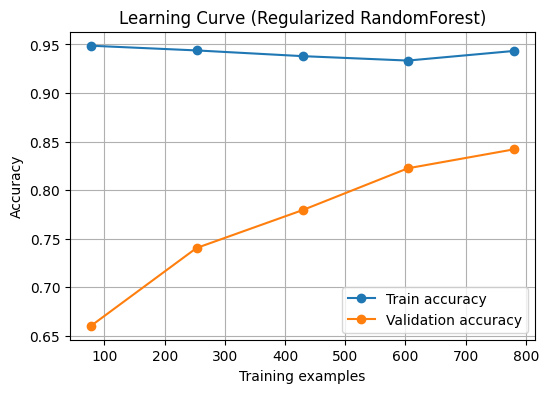

Confusion Matrix (best RF):
[[66 14  1]
 [ 8 54  5]
 [ 2  0 53]]


In [6]:
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, learning_curve
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Evaluate overfitting and try regularizing RandomForest with randomized search + learning curve
import matplotlib.pyplot as plt

# 1) CV accuracy on resampled training set
for name, model in [('RandomForest', rf), ('XGBoost', xgb)]:
    scores = cross_val_score(model, X_resampled, y_resampled, cv=cv, scoring='accuracy', n_jobs=-1)
    print(f"{name} CV accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

# 2) Randomized search to reduce RF complexity (regularize to reduce overfitting)
param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', 0.5]
}
rs = RandomizedSearchCV(rf, param_dist, n_iter=20, cv=cv, scoring='accuracy', n_jobs=-1, random_state=42)
rs.fit(X_resampled, y_resampled)
print("Best RF params:", rs.best_params_)

best_rf = rs.best_estimator_
y_test_pred_best = best_rf.predict(X_test_scaled)

print("Test accuracy (best RF):", (y_test_pred_best == y_test).mean())
print(classification_report(y_test, y_test_pred_best))

# 3) Learning curve to inspect gap between train and validation as training size grows
train_sizes, train_scores, val_scores = learning_curve(
    best_rf, X_resampled, y_resampled, cv=cv,
    train_sizes=np.linspace(0.1, 1.0, 5), scoring='accuracy', n_jobs=-1
)
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_mean, 'o-', label='Train accuracy')
plt.plot(train_sizes, val_mean, 'o-', label='Validation accuracy')
plt.xlabel('Training examples')
plt.ylabel('Accuracy')
plt.title('Learning Curve (Regularized RandomForest)')
plt.legend()
plt.grid(True)
plt.show()

# 4) Confusion matrix for quick error inspection
print("Confusion Matrix (best RF):")
print(confusion_matrix(y_test, y_test_pred_best))


=== RandomForest ===
Accuracy: 0.8522
              precision    recall  f1-score   support

           0       0.87      0.81      0.84        81
           1       0.79      0.81      0.80        67
           2       0.90      0.96      0.93        55

    accuracy                           0.85       203
   macro avg       0.85      0.86      0.86       203
weighted avg       0.85      0.85      0.85       203



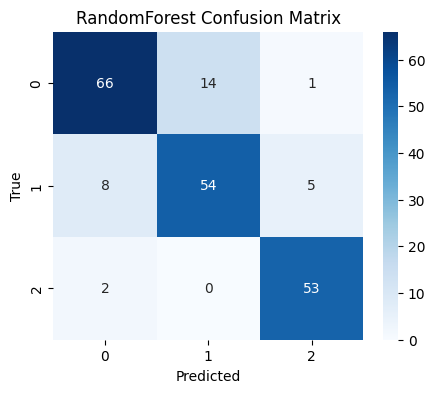

C:\Users\KIIT\AppData\Local\Temp\ipykernel_18956\1615836138.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[idx], y=feature_names[idx], palette="viridis")


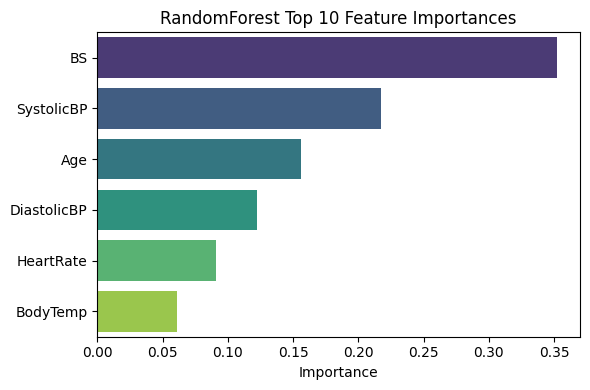

ROC AUC (macro, OVR): 0.9466


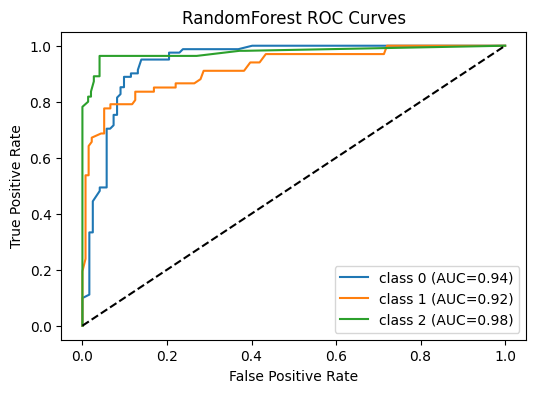


=== XGBoost ===
Accuracy: 0.8571
              precision    recall  f1-score   support

           0       0.86      0.84      0.85        81
           1       0.82      0.79      0.80        67
           2       0.90      0.96      0.93        55

    accuracy                           0.86       203
   macro avg       0.86      0.86      0.86       203
weighted avg       0.86      0.86      0.86       203



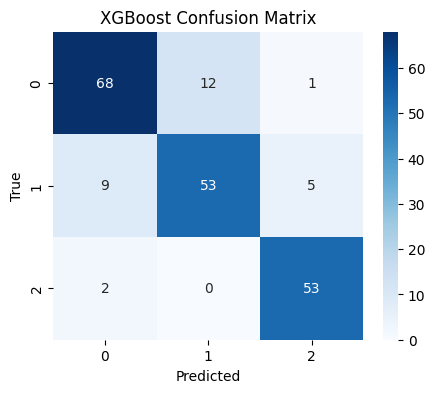

C:\Users\KIIT\AppData\Local\Temp\ipykernel_18956\1615836138.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[idx], y=feature_names[idx], palette="viridis")


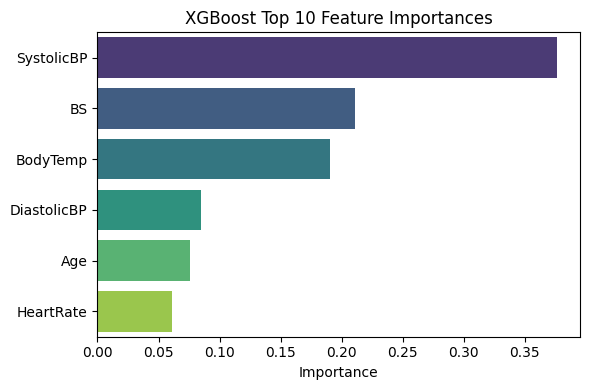

ROC AUC (macro, OVR): 0.9486


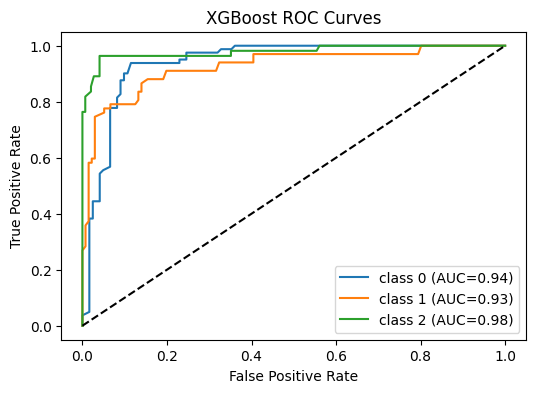

In [7]:
import numpy as np
import seaborn as sns
from sklearn.preprocessing import label_binarize

# Evaluation cell: run after models are trained (best_rf and xgb) and scaler/X_test_scaled/y_test exist
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve, auc
)

models = {"RandomForest": best_rf, "XGBoost": xgb}
y_true = np.array(y_test)
n_classes = len(np.unique(y_true))
y_test_binarized = label_binarize(y_true, classes=np.arange(n_classes))

feature_names = np.array(X.columns)

for name, m in models.items():
    print(f"\n=== {name} ===")
    y_pred = m.predict(X_test_scaled)
    print("Accuracy:", f"{accuracy_score(y_true, y_pred):.4f}")
    print(classification_report(y_true, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=[f"{i}" for i in range(n_classes)],
                yticklabels=[f"{i}" for i in range(n_classes)])
    plt.title(f"{name} Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("True")
    plt.show()

    # Feature importances (top 10) if available
    if hasattr(m, "feature_importances_"):
        importances = m.feature_importances_
        idx = np.argsort(importances)[::-1][:10]
        plt.figure(figsize=(6,4))
        sns.barplot(x=importances[idx], y=feature_names[idx], palette="viridis")
        plt.title(f"{name} Top 10 Feature Importances")
        plt.xlabel("Importance"); plt.tight_layout(); plt.show()

    # ROC AUC (multiclass OVR) and per-class ROC curves if predict_proba exists
    if hasattr(m, "predict_proba"):
        y_score = m.predict_proba(X_test_scaled)
        try:
            roc_auc = roc_auc_score(y_test_binarized, y_score, average="macro", multi_class="ovr")
            print("ROC AUC (macro, OVR):", f"{roc_auc:.4f}")
            plt.figure(figsize=(6,4))
            for i in range(n_classes):
                fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
                plt.plot(fpr, tpr, label=f"class {i} (AUC={auc(fpr,tpr):.2f})")
            plt.plot([0,1],[0,1],"k--")
            plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
            plt.title(f"{name} ROC Curves"); plt.legend(); plt.show()
        except Exception as e:
            print("ROC AUC computation failed:", e)
    else:
        print(f"{name} does not implement predict_proba(); skipping ROC AUC")


--- BestRF ---
              precision    recall  f1-score   support

         low       0.87      0.81      0.84        81
         mid       0.79      0.81      0.80        67
        high       0.90      0.96      0.93        55

    accuracy                           0.85       203
   macro avg       0.85      0.86      0.86       203
weighted avg       0.85      0.85      0.85       203


--- RandomForest ---
              precision    recall  f1-score   support

         low       0.87      0.80      0.83        81
         mid       0.79      0.81      0.80        67
        high       0.88      0.96      0.92        55

    accuracy                           0.85       203
   macro avg       0.85      0.86      0.85       203
weighted avg       0.85      0.85      0.85       203


--- XGBoost ---
              precision    recall  f1-score   support

         low       0.86      0.84      0.85        81
         mid       0.82      0.79      0.80        67
        high       0

,accuracy,balanced_accuracy,precision_macro,recall_macro,f1_macro,cohen_kappa
model,,,,,,
BestRF,0.8522,0.8615,0.8536,0.8615,0.8569,0.7765
RandomForest,0.8473,0.8574,0.8480,0.8574,0.8517,0.7693
XGBoost,0.8571,0.8647,0.8581,0.8647,0.8610,0.7836


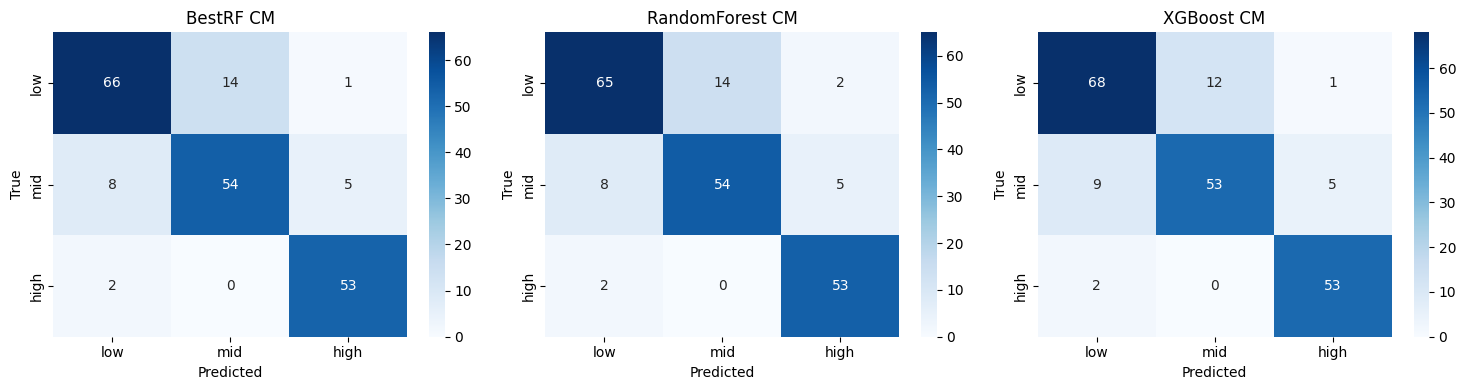

BestRF ROC AUC (macro, OVR): 0.9466
RandomForest ROC AUC (macro, OVR): 0.9501
XGBoost ROC AUC (macro, OVR): 0.9486


In [8]:
import pandas as pd
import seaborn as sns
import numpy as np

# Compare model predictions on the test set and plot confusion matrices + optional ROC AUC
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score,
    recall_score, f1_score, classification_report, confusion_matrix,
    cohen_kappa_score, roc_auc_score
)
import matplotlib.pyplot as plt

# Use existing variables: y_true (np.array), y_test_binarized (np.ndarray),
# X_test_scaled, best_rf, rf, xgb, and prediction arrays:
preds = {
    "BestRF": y_test_pred_best,
    "RandomForest": y_test_pred_rf,
    "XGBoost": y_test_pred_xgb
}
models_obj = {
    "BestRF": best_rf,
    "RandomForest": rf,
    "XGBoost": xgb
}

rows = []
for name, y_pred in preds.items():
    acc = accuracy_score(y_true, y_pred)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    prec_macro = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec_macro = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average="macro", zero_division=0)
    kappa = cohen_kappa_score(y_true, y_pred)
    rows.append({
        "model": name,
        "accuracy": acc,
        "balanced_accuracy": bal_acc,
        "precision_macro": prec_macro,
        "recall_macro": rec_macro,
        "f1_macro": f1_macro,
        "cohen_kappa": kappa
    })
    print(f"\n--- {name} ---")
    print(classification_report(y_true, y_pred, target_names=["low","mid","high"], zero_division=0))

results_df = pd.DataFrame(rows).set_index("model")
print("\nSummary metrics:")
display(results_df.round(4))

# Confusion matrices side-by-side
labels = ["low", "mid", "high"]
fig, axes = plt.subplots(1, len(preds), figsize=(15,4))
for ax, (name, y_pred) in zip(axes.flatten(), preds.items()):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax,
                xticklabels=labels, yticklabels=labels)
    ax.set_title(f"{name} CM")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
plt.tight_layout()
plt.show()

# Optional: compute multiclass ROC AUC (OVR) if predict_proba exists for model and X_test_scaled available
for name, m in models_obj.items():
    if hasattr(m, "predict_proba"):
        try:
            y_score = m.predict_proba(X_test_scaled)
            auc_macro = roc_auc_score(y_test_binarized, y_score, average="macro", multi_class="ovr")
            print(f"{name} ROC AUC (macro, OVR): {auc_macro:.4f}")
        except Exception as e:
            print(f"{name} ROC AUC failed: {e}")
    else:
        print(f"{name} has no predict_proba(); skipping ROC AUC")

In [9]:
from sklearn.metrics import accuracy_score

# Evaluate train/test accuracies and train-test gaps for available models

models = {"BestRF": best_rf, "RandomForest": rf, "XGBoost": xgb}
results = []

for name, m in models.items():
    # train on resampled training set (X_resampled / y_resampled)
    train_pred = m.predict(X_resampled)
    train_acc = accuracy_score(y_resampled, train_pred)

    # test predictions (use preds dict defined in the notebook)
    test_pred = preds[name]
    test_acc = accuracy_score(y_true, test_pred)

    gap = train_acc - test_acc
    abs_gap = abs(gap)
    results.append({
        "model": name,
        "train_acc": train_acc,
        "test_acc": test_acc,
        "gap": gap,
        "abs_gap": abs_gap
    })

res_df = pd.DataFrame(results).set_index("model").round(4)
print(res_df)

best_train_model = res_df["train_acc"].idxmax()
best_train_value = res_df["train_acc"].max()
best_test_model = res_df["test_acc"].idxmax()
best_test_value = res_df["test_acc"].max()
best_min_gap_model = res_df["abs_gap"].idxmin()
best_min_gap_value = res_df["abs_gap"].min()

print(f"\nBest train accuracy: {best_train_model} = {best_train_value:.4f}")
print(f"Best test  accuracy: {best_test_model} = {best_test_value:.4f}")
print(f"Smallest absolute train-test gap: {best_min_gap_model} = {best_min_gap_value:.4f}")

              train_acc  test_acc     gap  abs_gap
model                                             
BestRF           0.9395    0.8522  0.0873   0.0873
RandomForest     0.9395    0.8473  0.0922   0.0922
XGBoost          0.9395    0.8571  0.0823   0.0823

Best train accuracy: BestRF = 0.9395
Best test  accuracy: XGBoost = 0.8571
Smallest absolute train-test gap: XGBoost = 0.0823


In [10]:
from sklearn.metrics import accuracy_score

# Evaluate train/test accuracies and train-test gaps for available models

models = {"BestRF": best_rf, "RandomForest": rf, "XGBoost": xgb}
results = []

for name, m in models.items():
    # train on resampled training set (X_resampled / y_resampled)
    train_pred = m.predict(X_resampled)
    train_acc = accuracy_score(y_resampled, train_pred)

    # test predictions (use preds dict defined in the notebook)
    test_pred = preds[name]
    test_acc = accuracy_score(y_true, test_pred)

    gap = train_acc - test_acc
    abs_gap = abs(gap)
    results.append({
        "model": name,
        "train_acc": train_acc,
        "test_acc": test_acc,
        "gap": gap,
        "abs_gap": abs_gap
    })

res_df = pd.DataFrame(results).set_index("model").round(4)
print(res_df)

best_train_model = res_df["train_acc"].idxmax()
best_train_value = res_df["train_acc"].max()
best_test_model = res_df["test_acc"].idxmax()
best_test_value = res_df["test_acc"].max()
best_min_gap_model = res_df["abs_gap"].idxmin()
best_min_gap_value = res_df["abs_gap"].min()

print(f"\nBest train accuracy: {best_train_model} = {best_train_value:.4f}")
print(f"Best test  accuracy: {best_test_model} = {best_test_value:.4f}")
print(f"Smallest absolute train-test gap: {best_min_gap_model} = {best_min_gap_value:.4f}")

              train_acc  test_acc     gap  abs_gap
model                                             
BestRF           0.9395    0.8522  0.0873   0.0873
RandomForest     0.9395    0.8473  0.0922   0.0922
XGBoost          0.9395    0.8571  0.0823   0.0823

Best train accuracy: BestRF = 0.9395
Best test  accuracy: XGBoost = 0.8571
Smallest absolute train-test gap: XGBoost = 0.0823


In [11]:
from sklearn.metrics import accuracy_score

# Evaluate train/test accuracies and train-test gaps for available models

models = {"BestRF": best_rf, "RandomForest": rf, "XGBoost": xgb}
results = []

for name, m in models.items():
    # train on resampled training set (X_resampled / y_resampled)
    train_pred = m.predict(X_resampled)
    train_acc = accuracy_score(y_resampled, train_pred)

    # test predictions (use preds dict defined in the notebook)
    test_pred = preds[name]
    test_acc = accuracy_score(y_true, test_pred)

    gap = train_acc - test_acc
    abs_gap = abs(gap)
    results.append({
        "model": name,
        "train_acc": train_acc,
        "test_acc": test_acc,
        "gap": gap,
        "abs_gap": abs_gap
    })

res_df = pd.DataFrame(results).set_index("model").round(4)
print(res_df)

best_train_model = res_df["train_acc"].idxmax()
best_train_value = res_df["train_acc"].max()
best_test_model = res_df["test_acc"].idxmax()
best_test_value = res_df["test_acc"].max()
best_min_gap_model = res_df["abs_gap"].idxmin()
best_min_gap_value = res_df["abs_gap"].min()

print(f"\nBest train accuracy: {best_train_model} = {best_train_value:.4f}")
print(f"Best test  accuracy: {best_test_model} = {best_test_value:.4f}")
print(f"Smallest absolute train-test gap: {best_min_gap_model} = {best_min_gap_value:.4f}")

              train_acc  test_acc     gap  abs_gap
model                                             
BestRF           0.9395    0.8522  0.0873   0.0873
RandomForest     0.9395    0.8473  0.0922   0.0922
XGBoost          0.9395    0.8571  0.0823   0.0823

Best train accuracy: BestRF = 0.9395
Best test  accuracy: XGBoost = 0.8571
Smallest absolute train-test gap: XGBoost = 0.0823


In [13]:
import joblib

# Save sklearn/xgboost wrapper models and scaler used in the maternal health cells
joblib.dump(best_rf, r"C:\Users\KIIT\Desktop\VS_Code\GitHub\Major_Project\model_artifacts\maternal_best_rf.joblib")
joblib.dump(xgb, r"C:\Users\KIIT\Desktop\VS_Code\GitHub\Major_Project\model_artifacts\maternal_xgboost.joblib")
joblib.dump(scaler, r"C:\Users\KIIT\Desktop\VS_Code\GitHub\Major_Project\model_artifacts\maternal_scaler.joblib")

print("Saved: maternal_best_rf.joblib, maternal_xgboost.joblib, maternal_scaler.joblib")

Saved: maternal_best_rf.joblib, maternal_xgboost.joblib, maternal_scaler.joblib
